In [1]:
# Installing required packages
!pip install transformers
!pip install --upgrade --no-cache-dir gdown

     |████████████████████████████████| 3.5 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 20.6 MB/s 
     |████████████████████████████████| 6.5 MB 32.7 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=1708fab522d021589426e42d8c3a7276eebef729fb8af9e8acc2163922974a21
  Stored in directory: /tmp/pip-ephem-wheel-cache-u1720rlq/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdo

In [ ]:
# Downloading the dataset
!gdown --id <ID>

In [3]:
# importing required libraries and functions

import os
import json
import torch
import random
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from tokenizers import ByteLevelBPETokenizer
from transformers import AdamW
from transformers import RobertaTokenizer
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM
from transformers import pipeline

# EDA

In [4]:
# Reading the dataset
with open('/content/words_250000_train.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
    lines = lines[:-1]

print('Total no. of words :', len(lines))

Total no. of words : 227300


In [5]:
lengths = []
for i in lines:
  lengths.append(len(i))
print('Average Word Length :', sum(lengths)/len(lines))

Average Word Length : 9.347760668719754


In [6]:
mx_len = -1
for i in lines:
  mx_len = max(mx_len, len(i))
print('Maximum Word Length :', mx_len)

Maximum Word Length : 29


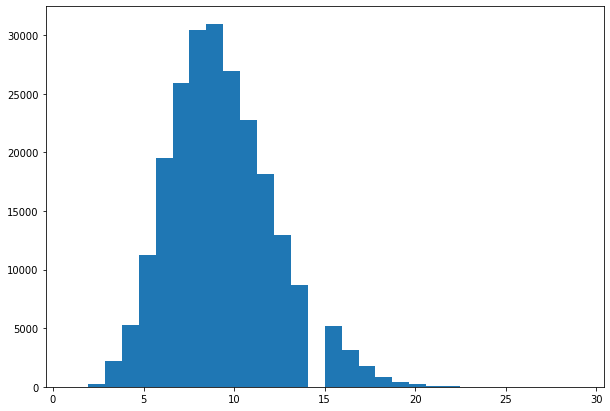

In [7]:
# Plotting word lenghts as histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(lengths, bins = 30)
plt.show()

In [8]:
# Finding most frequent alphabets
alph = 'abcdefghijklmnopqrstuvwxyz'
d = {}

for i in alph:
  d[i] = 0

for i in lines:
  vis = {}
  for j in i:
    if j not in vis:
      d[j] += 1
      vis[j] = 1

arr = []
for i in d:
  arr.append((d[i],i))
arr.sort(reverse=True)

fr_order = ''
for i,j in arr:
  fr_order += j + ' '

print('Alphabets in frequency order :', fr_order)

Alphabets in frequency order : e i a r n o s t l c u d p m h g y b f v k w z x q j 


In [9]:
tp5 = 'eiarn'

cnt = {2:0 , 3:0, 4:0, 5:0 }
for j in lines:
  vis = {}
  for i in j:
    if i in tp5:
      vis[i] = 1
  if len(vis)>=2:
    cnt[2] += 1
  if len(vis)>=3:
    cnt[3] += 1
  if len(vis)>=4:
    cnt[4] += 1
  if len(vis) == 5:
    cnt[5] += 1

print('Percent of words containing atleast 2 letters from top-5 :', cnt[2]/len(lines)*100)
print('Percent of words containing atleast 3 letters from top-5 :', cnt[3]/len(lines)*100)
print('Percent of words containing atleast 4 letters from top-5 :', cnt[4]/len(lines)*100)
print('Percent of words containing all the 5 letters from top-5 :', cnt[5]/len(lines)*100)

Percent of words containing atleast 2 letters from top-5 : 89.04223493180818
Percent of words containing atleast 3 letters from top-5 : 64.74615046194457
Percent of words containing atleast 4 letters from top-5 : 30.55829300483942
Percent of words containing all the 5 letters from top-5 : 7.177738671359436


# Building the RoBERTa model

In [10]:
# Tokenizer to map alphabets to vector

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(files='words_250000_train.txt', vocab_size=30, special_tokens=['<s>', '<pad>', '</s>', '<mask>'])
try:
  os.mkdir('./myberto')
except:
  print('Already Exists!')
tokenizer.save_model('myberto')

dictionary = {"<s>":0,"<pad>":1,"</s>":2,"<mask>":3,"a":4,"b":5,"c":6,"d":7,"e":8,"f":9,"g":10,"h":11,"i":12,"j":13,"k":14,"l":15,"m":16,"n":17,"o":18,"p":19,"q":20,"r":21,"s":22,"t":23,"u":24,"v":25,"w":26,"x":27,"y":28,"z":29}
with open("myberto/vocab.json", "w") as outfile:
    outfile.write( json.dumps(dictionary) )

# initialize the tokenizer using the tokenizer we initialized and saved to file
tokenizer = RobertaTokenizer.from_pretrained('myberto')    

file myberto/config.json not found
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


In [11]:
# Splitting the given data into test and train set

p = 0.05
ind_arr = list(range( len(lines) ))
test_inds = random.sample(ind_arr, int(p*len(lines)))

test_set = []
d = {}
for i in test_inds:
  test_set.append(lines[i])
  d[i] = True

train_set = []
for i in range(len(lines)):
  if i not in d:
    train_set.append(lines[i])

print('No. of words in Train set :', len(train_set))
print('No. of words in Test set :', len(test_set))

No. of words in Train set : 215935
No. of words in Test set : 11365


In [12]:
# Vectorizing the training data
batch = tokenizer(train_set, max_length=mx_len, padding='max_length', truncation=True)

labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])

# make copy of labels tensor, this will be input_ids
input_ids = labels.detach().clone()
# create random array of floats with equal dims to input_ids
rand = torch.rand(input_ids.shape)
# mask random 15% where token is not 0 [PAD], 1 [CLS], or 2 [SEP]
mask_arr = (rand < .25) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
# loop through each row in input_ids tensor (cannot do in parallel)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    nums = {}
    for j in selection:
      nums[ input_ids[i, j].item() ] = True
    for j in range(mx_len):
      if input_ids[i, j].item() in nums:
        input_ids[i, j] = 3  # our custom [MASK] token == 3

In [13]:
# Loading dataset as Tensor
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

dataset = Dataset(encodings)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [14]:
# Loading the RoBERTa model with given config
config = RobertaConfig(
    vocab_size=30,  # we align this to the tokenizer vocab_size
    max_position_embeddings=32,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
)
model = RobertaForMaskedLM(config)

In [15]:
# Using GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=1)
      (position_embeddings): Embedding(32, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [16]:
# Activate training mode
model.train()
# Initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
# Training

epochs = 2
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        # print(input_ids.shape)
        # print(attention_mask.shape)
        # print(labels.shape)
        # print(input_ids[0])
        outputs = model(input_ids, attention_mask=attention_mask,labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

# Saving the model weights
model.save_pretrained('./myberto') 

  0%|          | 0/13496 [00:00<?, ?it/s]

  0%|          | 0/13496 [00:00<?, ?it/s]

# Evaluating model

In [18]:
# Defining a pipeline and loading saved model weights
fill = pipeline('fill-mask', model='myberto', tokenizer='myberto')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [26]:
# Evaluating the trained model
cnt = 0
crt_cnt = 0
limit = 6
special_tokens = ['<s>', '<pad>', '</s>', '<mask>']
fr_arr = list('eiarnostlcudpmhgybfvkwzxqj')

for word in test_set[1050:1100]:

  wrg_gs = 0  
  gs = 0
  chk = False
  used_letters = {}
  cnt += 1

  while wrg_gs < limit:
    
    chk = True
    tmp = ''
    msk_cnt = 0
    for i in word:
      if i in used_letters:
        tmp += i
      else:
        chk = False
        tmp += '<mask>'
        msk_cnt += 1
    
    if chk:
      break
    
    if gs<5:
      cur_gs = fr_arr[gs]
    else:
      pred = fill(tmp, top_k=30)
      if msk_cnt == 1:
        pred = [ pred ]
      arr_g = []
      for p in pred:
        for i in p:
          arr_g.append((i['score'], i['token_str']))
      arr_g.sort(reverse = True)
      for j,i in arr_g:
        if i not in special_tokens and i not in used_letters:
          cur_gs = i
          break
    if cur_gs not in word:
      wrg_gs += 1
    used_letters[cur_gs] = 1
    gs += 1

  if chk:
    crt_cnt += 1

  if cnt%10 == 0:  
    print('current win percent :',crt_cnt/cnt)

print()
print('Final Result')
print('---------------------------')
print('Total Games won :', crt_cnt)
print('Total Games played :', cnt)
print('Win percent :', crt_cnt/cnt)


current win percent : 0.7
current win percent : 0.6
current win percent : 0.6333333333333333
current win percent : 0.6
current win percent : 0.5

Final Result
---------------------------
Total Games won : 25
Total Games played : 50
Win percent : 0.5
